# NLP Project: Amazon Alexa review

#Chapter 1: Dataset Description and machine learning multi-class classification


We import the main packages

In [0]:
!pip install emoji

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=a7373d0a2437e206e586a7a95abe2933cb9f440c547e62a9fcbf0c1f87827f3d
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
# Importation of the main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import emoji
import seaborn as sns
import string
import re
from pprint import pprint
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score, classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Import the Amazon Alexa Reviews dataset from google drive

In [0]:
 # !pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_id = "1ua1fTEsKDCGnGADEyDXturMeFe7soPbp"
downloaded = drive.CreateFile({'id':file_id})  
downloaded.GetContentFile('amazon_alexa.tsv')

df = pd.read_csv("amazon_alexa.tsv", sep="\t")

In [0]:
df.head()

,rating,date,variation,verified_reviews,feedback,reviews
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Charcoal Fabric Love my Echo!
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Charcoal Fabric Loved it!
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,"Walnut Finish Sometimes while playing a game,..."
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Charcoal Fabric I have had a lot of fun with ...
4,5,31-Jul-18,Charcoal Fabric,Music,1,Charcoal Fabric Music


In [0]:
# Statistic for us
df.variation.unique() 
df.variation.value_counts()

Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

We will gather together the textual variables.

In [0]:
df["reviews"] = df["variation"] + " " + df["verified_reviews"]

# 1. We now study our variables

We would like to see the distribution of the rating with their respective weights.

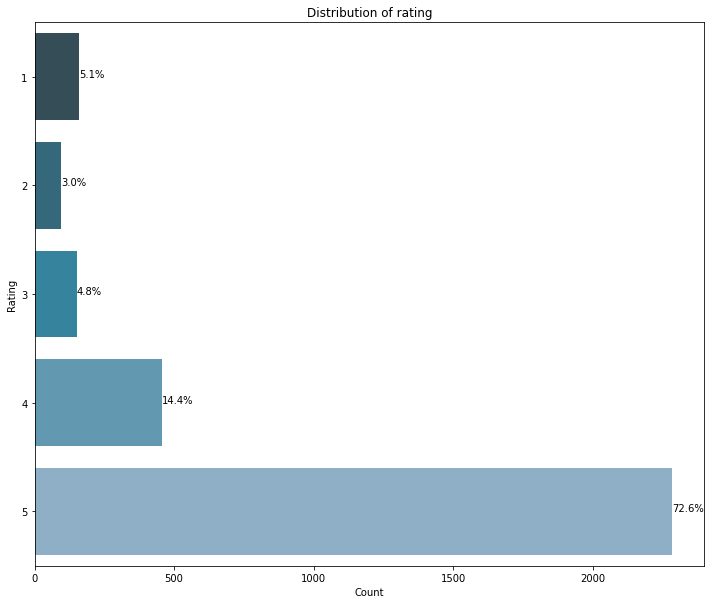

In [0]:
plt.figure(figsize=(12,10))
ax = sns.countplot(y = "rating", data = df,  palette="PuBuGn_d")
plt.title("Distribution of rating")
plt.xlabel("Count")
plt.ylabel("Rating")


total = len(df["rating"])
for p in ax.patches:
    percentage = "{:.1f}%".format(100*p.get_width()/total)
    x = p.get_x() + p.get_width()+0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x,y))

We can see on this graph that our data is unbalanced.

We had install the emoji packages for take account in the verified_rewiews

## 1.1 Descriptive statistics

We construct a function to summarize the differences and similarities for the rating 

In [0]:
def transform(X):
  """
  Description : We transform the raw data in order to have some basic statistic

  Return : dataframe
  """
  count_word = X.apply(lambda x: re.findall(r"\w+", x)).apply(len)
  count_questions = X.apply(lambda x: re.findall(r"(?:[\?].*){2,}", x)).apply(len)
  count_length_word = X.apply(lambda x : len(x))
  count_nber_sentence = X.apply(lambda x: len(str(x).split(". ")))
  count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: re.findall(r':[a-z_&]+:', x)).apply(len)
  count_exclamation = X.apply(lambda x: re.findall(r"!",x)).apply(len)

  df = (pd.DataFrame({"count_word": count_word, "count_questions": count_questions, 
                      "count_length_word" : count_length_word, "count_nber_sentence" : count_nber_sentence,
                      "count_emojis" : count_emojis, "count_exclamation" : count_exclamation})).reset_index()
  return df


def processing_html_code(x):
  """
  Description : replace the html code to "understandable" code

  Return : the same object as the input 
  """
  return x.apply(lambda x : x.replace("&#34;", "'") if x.find("&#34")>0 else x) 

  
def show_dist(df, col):
  print('Descriptive stats for {}'.format(col))
  print('-'*(len(col)+22))
  print(df.groupby('rating')[col].describe())
  bins = np.arange(df[col].min(), df[col].max() + 1)
  g = sns.FacetGrid(df, col='rating', size=5, hue='rating', palette="PuBuGn_d")
  g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
  plt.show()

Descriptive stats for count_word
--------------------------------
         count       mean        std  min   25%   50%   75%    max
rating                                                            
1        161.0  37.472050  40.560150  0.0   6.0  24.0  53.0  237.0
2         96.0  48.718750  52.215082  0.0  15.0  33.0  60.0  319.0
3        152.0  40.848684  52.936143  0.0  10.0  27.0  52.5  374.0
4        455.0  35.101099  42.376001  0.0   7.0  19.0  49.0  267.0
5       2286.0  21.325459  30.041677  0.0   5.0  12.0  27.0  557.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


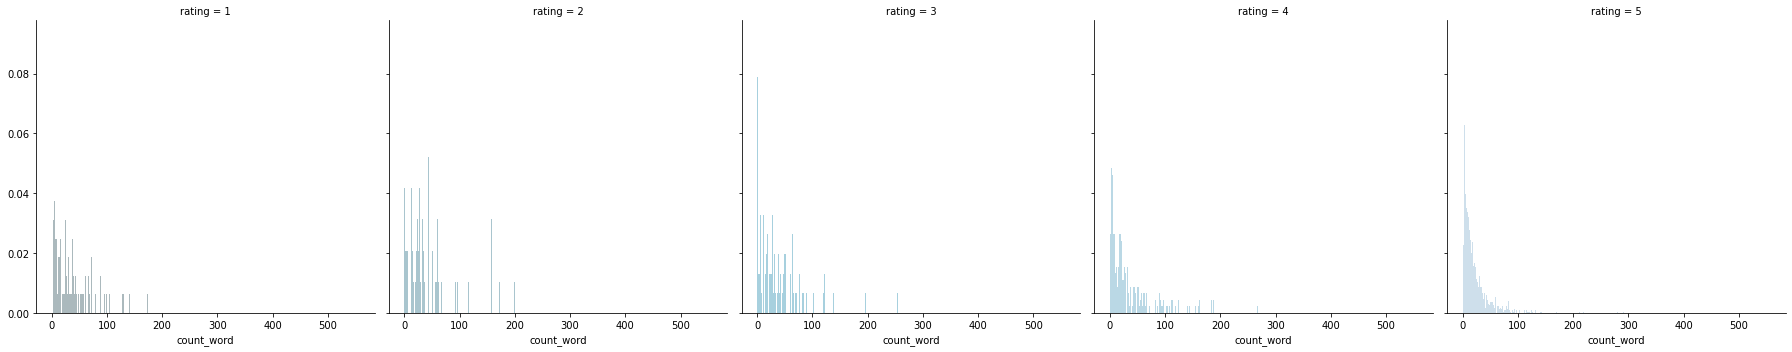

Descriptive stats for count_questions
-------------------------------------
         count      mean       std  min  25%  50%  75%  max
rating                                                     
1        161.0  0.049689  0.217981  0.0  0.0  0.0  0.0  1.0
2         96.0  0.020833  0.143576  0.0  0.0  0.0  0.0  1.0
3        152.0  0.006579  0.081111  0.0  0.0  0.0  0.0  1.0
4        455.0  0.008791  0.093451  0.0  0.0  0.0  0.0  1.0
5       2286.0  0.001750  0.041803  0.0  0.0  0.0  0.0  1.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


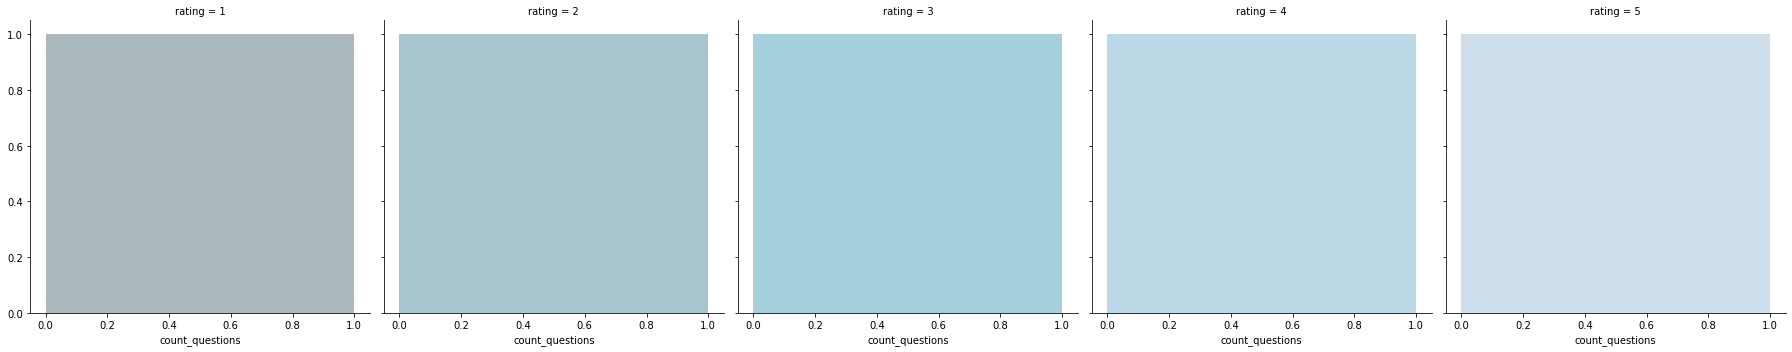

Descriptive stats for count_length_word
---------------------------------------
         count        mean         std  min    25%    50%     75%     max
rating                                                                   
1        161.0  195.000000  212.371226  1.0  36.00  120.0  284.00  1124.0
2         96.0  249.187500  269.595303  1.0  78.75  163.0  309.25  1686.0
3        152.0  207.296053  272.194706  1.0  54.00  130.0  284.00  1954.0
4        455.0  178.520879  215.927849  1.0  34.00   99.0  241.00  1360.0
5       2286.0  108.444007  152.116387  1.0  26.00   64.0  135.00  2851.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


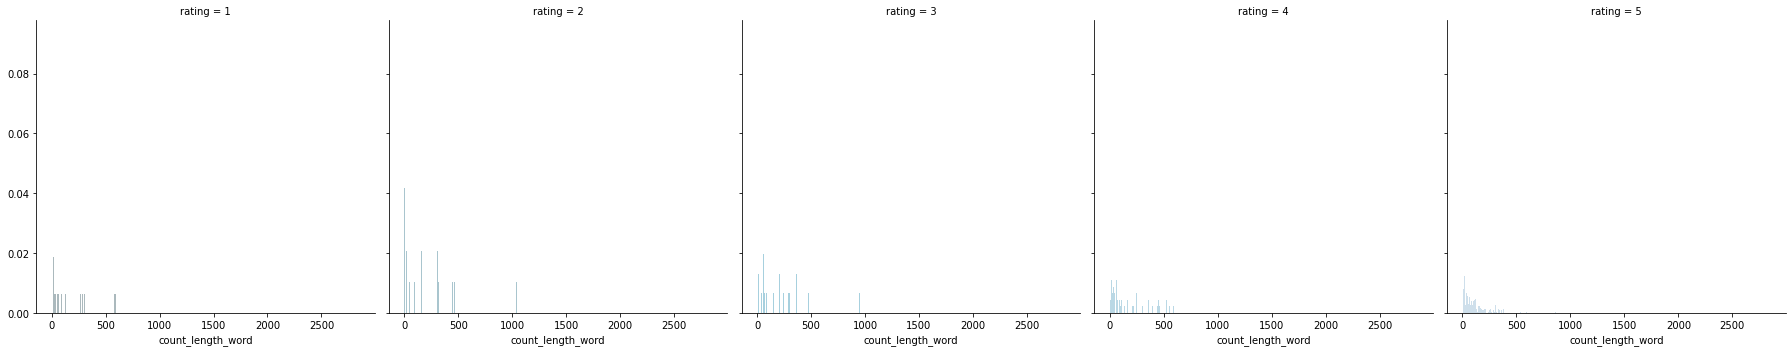

Descriptive stats for count_exclamation
---------------------------------------
         count      mean       std  min  25%  50%  75%   max
rating                                                      
1        161.0  0.459627  1.646943  0.0  0.0  0.0  0.0  15.0
2         96.0  0.072917  0.441166  0.0  0.0  0.0  0.0   4.0
3        152.0  0.131579  0.535918  0.0  0.0  0.0  0.0   4.0
4        455.0  0.167033  0.529536  0.0  0.0  0.0  0.0   5.0
5       2286.0  0.524497  1.083016  0.0  0.0  0.0  1.0  14.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


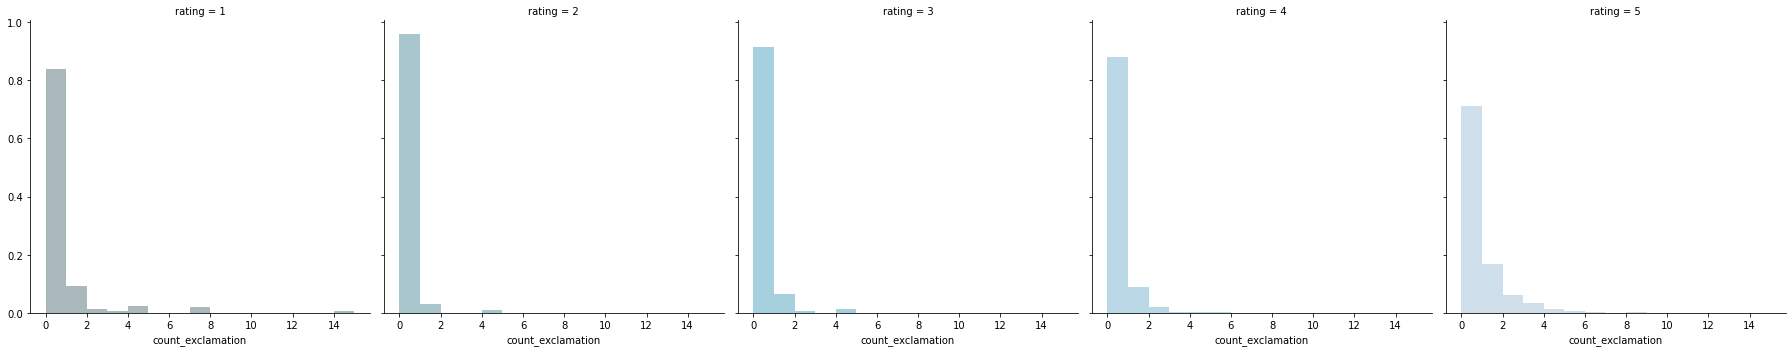

Descriptive stats for count_emojis
----------------------------------
         count      mean       std  min  25%  50%  75%  max
rating                                                     
1        161.0  0.006211  0.078811  0.0  0.0  0.0  0.0  1.0
2         96.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
3        152.0  0.026316  0.160602  0.0  0.0  0.0  0.0  1.0
4        455.0  0.019780  0.251961  0.0  0.0  0.0  0.0  5.0
5       2286.0  0.013561  0.190105  0.0  0.0  0.0  0.0  5.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


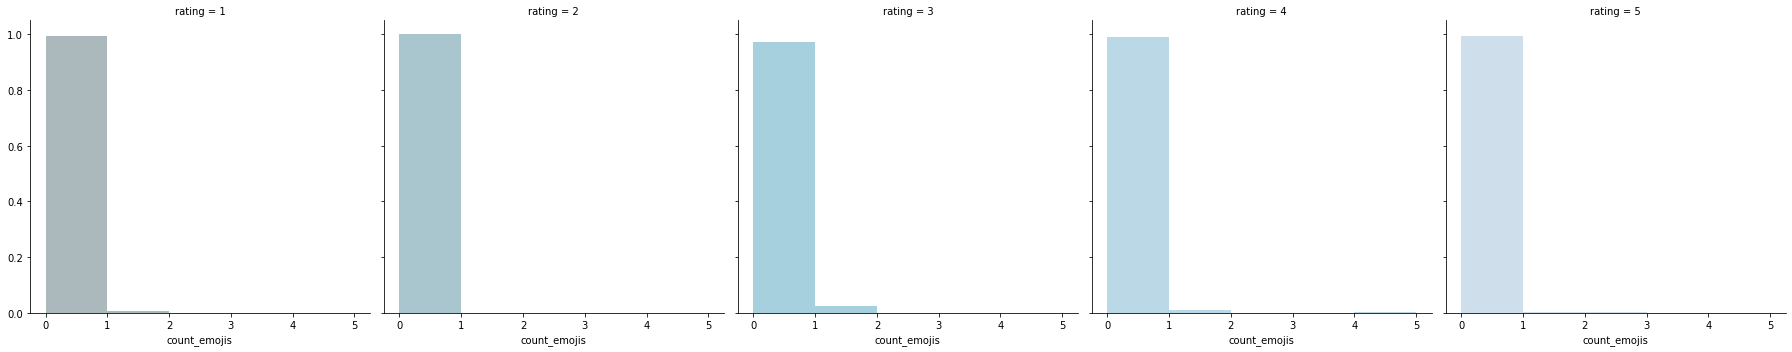

In [0]:
basic_statistic = processing_html_code(df["verified_reviews"])
basic_statistic = transform(df["verified_reviews"])
basic_statistic["rating"] = df.rating
for variable in ["count_word", "count_questions", "count_length_word", "count_exclamation", "count_emojis"]:
    show_dist(basic_statistic,  variable)

According to the descriptive statistics, we can see that on average the lower rated have a higher number of words (i.e. 37 words on average for the rating 1 against 21 for the rating 5) than those who have a higher rating. This corroborates our initial idea that people who are disappointed with Alexa's product are expected to write a longer text than people who are happy with the product. Nevertheless, the maximum is higher for the 5 rating than for the 4 others, it is probably a person who liked the product a lot and wanted to share his enthusiasm.

Moreover, bad ratings have a higher number of question marks than those with high ratings. There are 28 times as many question marks in rating 1 as in rating 5.  The number of question marks decreases continuously with the increase of the rating score. The same applies to the standard deviation. Once again, this reinforces our assumptions that a dissatisfied person will have a stronger tendency to ask questions. However, we will not use this information in the following because the question marks are too infrequent to have an impact in our model. 

As far as word length is concerned, the same comment as for the number of words applies to the words except that the rating 3 seems to have a distinct behaviour. Indeed, it is expected that people who assign a low rating to the product will choose longer words than others because negative-sounding words such as dislike are longer than positive-sounding words. However, in the case of a rating of 3, the word length is about the same, except that the standard deviation is greater. The people belonging to this rating are people who can be described as indecisive on the product and therefore they go up both the bad ratings and the good ones, which means that on average, the word length is longer.

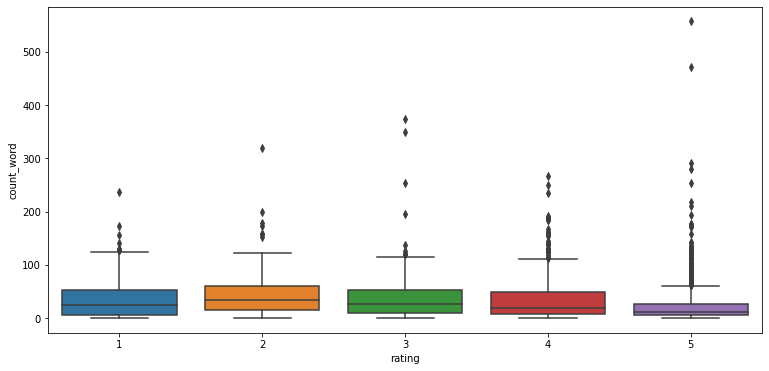

In [0]:
plt.figure(figsize=(12.8, 6))
sns.boxplot(data = basic_statistic, x = "rating", y = "count_word");

Now, for better comprehension and visualization, we remove the larger documents

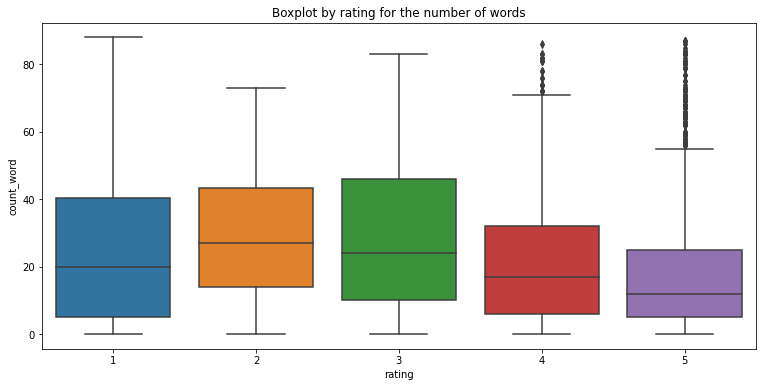

In [0]:
quantile_95 = basic_statistic["count_word"].quantile(0.95)
bs_95qtl = basic_statistic[basic_statistic["count_word"]< quantile_95]
plt.figure(figsize=(12.8, 6))
plt.title("Boxplot by rating for the number of words")
sns.boxplot(data = bs_95qtl, x = "rating", y = "count_word")

We can see on the graph that the distribution of the number of words is almost similar between the different ratings when we remove the larger values. Except for ratings 4 and 5, which correspond to the positive categories. As far as ratings 1 and 2 (i.e. negative rating) are concerned, they seem to have a higher number of words than ratings 4 and 5. One can see a strong standard deviation for rating 1 in the number of words. Rating 3 has a number of words close to the negative rating.

# 2. We now move on data cleaning


- In First, we try to remove all the special caracters
- Then, we put all the word in lowercase
- After we remove the punctuation
- We remove the stop words

In [0]:
!pip install nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def remove_car(input_text):
    return [re.sub(r'[^A-za-z0-9]', ' ', w) for w in input_text] 

def remove_punct(input_text):
    return "".join([car for car in input_text if car not in string.punctuation])

def remove_stopwords(input_text):
    words = [w for w in input_text if w not in stopwords.words("english")]
    return words

lemmatizer = WordNetLemmatizer()
def word_lemmatizer(intput_text):
    text = [lemmatizer.lemmatize(i) for i in intput_text]
    return text

stemmer = PorterStemmer()
def word_stemmer(input_text):
    text = " ".join([stemmer.stem(i) for i in input_text])
    return text

In [0]:
train_reviews = [elmt for elmt in df["reviews"]]
train_reviews[:10]

['Charcoal Fabric  Love my Echo!',
 'Charcoal Fabric  Loved it!',
 'Walnut Finish  Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.',
 'Charcoal Fabric  I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.',
 'Charcoal Fabric  Music',
 'Heather Gray Fabric  I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do.',
 'Sandstone Fabric  Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random

In [0]:
exemple = df["reviews"].apply(lambda x : remove_car(x))
exemple = exemple.apply(lambda x : remove_punct(x))

## 2.1 Tokenizer

For the process of tokenization, we use the word tokenization which is the process of splitting sentences into their constituent words. A sentence is just a collection of words and with tokenization we essentially split a sentence into a list of words that can be used to reconstruct the sentence. Word tokenization is really important in many processes, especially in cleaning and normalizing text where operations like stemming and lemmatizing work on each individual word based on its respective stems and lemma.  

In [0]:
from nltk.tokenize import RegexpTokenizer 
tokenizer = RegexpTokenizer(r'\w+')
exemple = exemple.apply(lambda x: tokenizer.tokenize(x.lower()))
exemple[:10]

0                   [charcoal, fabric, love, my, echo]
1                        [charcoal, fabric, loved, it]
2    [walnut, finish, sometimes, while, playing, a,...
3    [charcoal, fabric, i, have, had, a, lot, of, f...
4                            [charcoal, fabric, music]
5    [heather, gray, fabric, i, received, the, echo...
6    [sandstone, fabric, without, having, a, cellph...
7    [charcoal, fabric, i, think, this, is, the, 5t...
8                [heather, gray, fabric, looks, great]
9    [heather, gray, fabric, love, it, i, ve, liste...
Name: reviews, dtype: object

In [0]:
exemple = exemple.apply(lambda x: remove_stopwords(x))
exemple[:10]

0                       [charcoal, fabric, love, echo]
1                            [charcoal, fabric, loved]
2    [walnut, finish, sometimes, playing, game, ans...
3    [charcoal, fabric, lot, fun, thing, 4, yr, old...
4                            [charcoal, fabric, music]
5    [heather, gray, fabric, received, echo, gift, ...
6    [sandstone, fabric, without, cellphone, cannot...
7    [charcoal, fabric, think, 5th, one, purchased,...
8                [heather, gray, fabric, looks, great]
9    [heather, gray, fabric, love, listened, songs,...
Name: reviews, dtype: object

The difference between the lemmatization and stemmer process is that the root stem may not always be a lexicographically correct word, i.e., it may not be present in the dictionary but the root word, also known as the lemma, will always be present in the dictionary.

In [0]:
exemple = exemple.apply(lambda x: word_lemmatizer(x))
exemple[:10]

0                       [charcoal, fabric, love, echo]
1                            [charcoal, fabric, loved]
2    [walnut, finish, sometimes, playing, game, ans...
3    [charcoal, fabric, lot, fun, thing, 4, yr, old...
4                            [charcoal, fabric, music]
5    [heather, gray, fabric, received, echo, gift, ...
6    [sandstone, fabric, without, cellphone, cannot...
7    [charcoal, fabric, think, 5th, one, purchased,...
8                 [heather, gray, fabric, look, great]
9    [heather, gray, fabric, love, listened, song, ...
Name: reviews, dtype: object

In [0]:
exemple = exemple.apply(lambda x: word_stemmer(x))
exemple[:10]

0                            charcoal fabric love echo
1                                 charcoal fabric love
2    walnut finish sometim play game answer questio...
3    charcoal fabric lot fun thing 4 yr old learn d...
4                                charcoal fabric music
5    heather gray fabric receiv echo gift need anot...
6    sandston fabric without cellphon cannot use ma...
7    charcoal fabric think 5th one purchas work get...
8                       heather gray fabric look great
9    heather gray fabric love listen song heard sin...
Name: reviews, dtype: object

## 2.2 We test a other method for tokenization

In [0]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm
def tokenize_reviews(corpus):
    ''' modified version for our data structure '''
    tokenized_sentences = []
    for sample in tqdm(corpus):
        tokenizer = word_tokenize
        tokens = sample
        tokens = tokenizer(sample)
        tokens = remove_car(tokens)
        tokens = remove_stopwords(tokens)
        tokens = list(map(lambda x: x.lower(), tokens))
        tokenized_sentences.append(tokens)
    return tokenized_sentences

In [0]:
X_v2 = tokenize_reviews(df.reviews.array)
X_v2 = [' '.join(x) for x in X_v2]
print(len(X_v2), X_v2[0])
print(len(df.verified_reviews.array), df.verified_reviews.array[0])

100%|██████████| 3150/3150 [00:12<00:00, 260.45it/s]

3150 charcoal fabric love echo  
3150 Love my Echo!


# 3. Now we can analyse the text

## 3.1  First modelization

In a supervised classification task it is a good practice to slit the dataset into 3 sets:
- Training set: 60%: used to train the classifier and obtain a model
- Dev set: 20%: used to apply the model and check performance while tuning it
- Test set: 20% used as the final performance check to see if the generalization is ok

In [0]:
# Create train 60% 
from sklearn.model_selection import train_test_split
y = df.rating
X_train, X_devtest, y_train, y_devtest = train_test_split(X_v2, y, test_size=0.4, random_state=42)
print(X_train[:10])
print(y_train[:10])

['configuration   fire tv stick it  s constantly buffering   point ca n t watch anything without interruption   i purchased prime day plus i used rewards pay   end i paid next nothing   if i paid full price i might want money back   we stopped trying use went back old streaming device   i know internet service issue problem devices stream  ', 'charcoal fabric just getting use using echo   used shopping lists   listening music timer   working great far  ', 'white show works great use arlo security system', 'white plus', 'black plus coop product many uses including smart devices throughout home', 'black show met every expectation i', 'charcoal fabric how easy set  ', 'configuration   fire tv stick does work tube tv', 'charcoal fabric works advertised', 'black plus really cool device ton stuff   fun games like jeopardy   we used set smart bulbs light switches   make sure ge stuff corresponds particular hub   had make runs back store exchanges  ']
2330    2
300     5
1509    5
2019    1
18

In [0]:
# create dev 20% test 20% (hence 50% from the 40%)
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)
print(X_dev[:10])
print(y_dev[:10])

['black dot', 'black dot we still discovery phase   far enjoying smart home features installed  ', 'charcoal fabric great sound small package easy set use   fun  ', 'black spot love     super fun   easy use   my three year old even gets involved', 'black spot perfect   may favorite alexa device far   specially ring cameras amazon cam  s job really well   we changed echo main living room seems reactive   good job amazon  ', 'black show we love show   it loses connection every sure show issue internet issue   but overall use many applications  ', 'charcoal fabric great device   seems work better 1st generation  ', 'black dot enjoying still learning commands   ran one frustrating issue   it user friendly trying set voice recognition household  ', 'white spot i dot echo plus   one ca n t seem     34   hear     34   well n t much i expected  ', 'black plus i purchase echo plus built hub came free philips hue bulb   when i got everything set   i realized echo plus hub   allow full functional

### 3.1.1 Preprocessing Text and Labels

Then we use the method of CountVectorizer for transform the text to vector

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,1)) #strip_accents = "unicode", decode_error= "replace", stop_words = "english",
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(1890, 3325)

In [0]:
# for dev set
X_dev_cv = cv.transform(X_dev)
X_dev_cv.shape

(630, 3325)

Then we label the target variable.

In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)
y_train_lb = lb_trained.transform(y_train)
y_dev_lb = lb_trained.transform(y_dev)
print(y_train_lb.shape, y_dev_lb.shape)

(1890, 5) (630, 5)


Then, we make a random forest with the CountVectorizer and the label target variable

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=300, max_depth=None, class_weight = "balanced", random_state=42, n_jobs=-1, verbose=1)
rfc.fit(X_train_cv, y_train_lb)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

Then, we make the prediction

In [0]:
y_pred_rfc = rfc.predict(X_dev_cv)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.2s finished


In [0]:
accuracy_score_rf=accuracy_score(y_dev_lb,y_pred_rfc)

The second model is expected to score worse than the first because we took the raw text without cleaning it up. So we have all the "stopwords".

In [0]:
print("Accuracy score for Random Forest for another classifier: ",accuracy_score_rf)

Accuracy score for Random Forest for another classifier:  0.726984126984127


We first tried a model without reprocessing to see the performance of the model.  The model gives the same level of accuracy as if the model predicted the dominant class.

## 3.2 Second modelization

### 3.2.1 We separate the dataframe in train and test for the first method of tokenization

In [0]:
# creating the Bag of words Model
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=1500)
X=cv.fit_transform(exemple).toarray()
y=df.iloc[:,0].values

In [0]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [0]:
np.unique(y, return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 161,   96,  152,  455, 2286]))

In [0]:
np.unique(y_train, return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 128,   75,  113,  365, 1839]))

### 3.2.2 Model

In [0]:
# Fitting Random Forest classifier with 100 trees to the Training set
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
y_pred_rf=rf.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix
report_rf2 = classification_report(y_test, y_pred_rf, output_dict = True)
accuracy_score_rf2= report_rf2["accuracy"]
f1_score_rf2 = report_rf2["macro avg"]["f1-score"]
matrix_conf = confusion_matrix(y_test, y_pred_rf)

In [0]:
print("F1 score: ",f1_score_rf2)

F1 score:  0.5432907005803742


Normalized confusion matrix


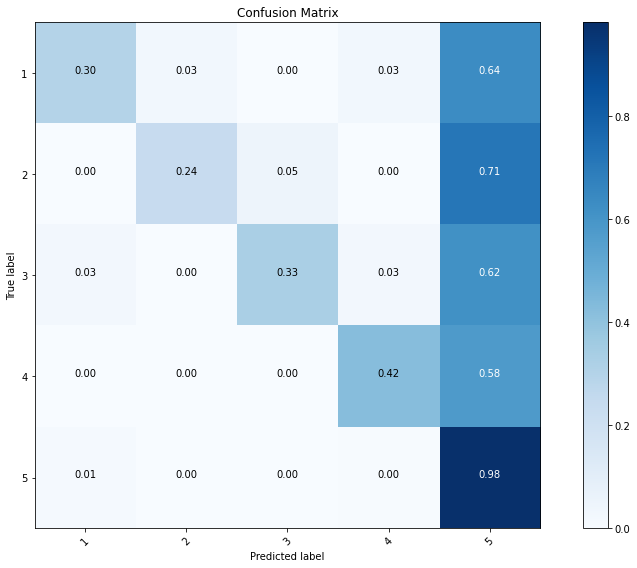

In [0]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure(figsize=(12.0,8.0))
plot_confusion_matrix(matrix_conf, classes = ["1","2","3","4","5"], title = "Confusion Matrix", normalize = True)

In [0]:
print("Random Forest=",accuracy_score_rf2)

Random Forest= 0.8015873015873016


We could be happy with the accuracy of our classifier. However, we have to remember that our classes are unbalanced and we have seen that the rating 5 represents 73% of our observations. So, a dumb classifier that predicts the majority class would have an accuracy of 73%. In a first step, we make estimates without "equilibrating" the classes.

### 3.2.3 Cross validation

In [0]:
print("Parameter used at time t0: \n")
pprint(rf.get_params())

Parameter used at time t0: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


We try to optimize the **hyperparameter** of the model which are:
- n_estimators
- max_features
- max_depth
- min_samples_split
- min_samples_leaf
- boostrap

In [0]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']


# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 325, 550, 775, 1000]}


In [0]:
# We define the model for tune it
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 0, class_weight = "balanced", n_jobs=-1, verbose=1)

# Definition of the random seach
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = rfc, 
                                   param_distributions = random_grid, 
                                  n_iter = 50,
                                  scoring = "accuracy",
                                  cv = 3)

random_search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 775 out of 775 | elapsed:   10.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 775 out of 775 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 775 out of 775 | elapsed:    9.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | ela

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
      

We can see the best hyperparameters resulting from the Random Search:

In [0]:
print("The best hyperparameters from Random Search are:")
pprint(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
pprint(random_search.best_score_)

The best hyperparameters from Random Search are:
{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 550}

The mean accuracy of a model with these hyperparameters is:
0.765079365079365


In [0]:
random_search.best_estimator_
#random_search.predict_proba(X_test)[:5]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=60, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [0]:
y_pred_rf_cv=random_search.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 550 out of 550 | elapsed:    0.2s finished


In [0]:
report_rf_cv = classification_report(y_test,y_pred_rf_cv, output_dict = True)
accuracy_score_rf_cv = report_rf_cv["accuracy"]
f1_score_rf_cv = report_rf_cv["macro avg"]["f1-score"]
print("Accuracy score for balanced estimation: ", accuracy_score_rf_cv)
matrix_conf = confusion_matrix(y_test, y_pred_rf_cv)

Accuracy score for balanced estimation:  0.7888888888888889


In [0]:
print("F1 score for balanced estimation: ", f1_score_rf_cv)

F1 score for balanced estimation:  0.5465491421112796


Normalized confusion matrix


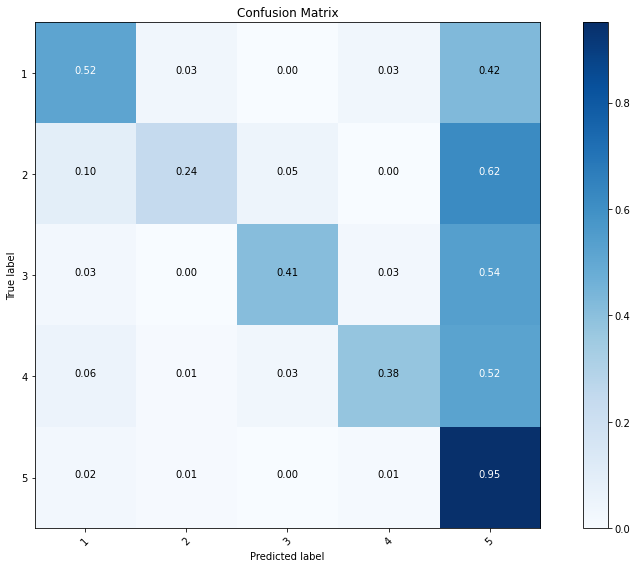

In [0]:
plt.figure(figsize=(12.0,8.0))
plot_confusion_matrix(matrix_conf, classes = ["1","2","3","4","5"], title = "Confusion Matrix", normalize = True)

We can see that with random search we can better predict the rating 1. Our model loses a little bit of accuracy compared to the "idiot" model. In the matrix, we can see that the rating 1 is predicted at 50% in rating 5 and at 50% in rating 1. Previously, the model predicted the rating 1 at more than 60% in rating 5. We managed to reduce the error even if it is not enough. We notice that the model has difficulty in predicting rating 4. Maybe we should group ratings 4 and 5 together as well as ratings 1 and 2. We leave this choice open.

## 3.3 We will try to implement a TF-IDF by rating

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


class TfIdfLabel(TfidfVectorizer):
    """
    This function class is based on the TF-IDF model of scikit learn except that we want to do it by Y labels.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)

    def transform(self, x, y=None):
        res = super().transform(x)
        df = pd.DataFrame(res.toarray(), columns=self.get_feature_names())
        return df

    def fit_transform(self, x, y=None):
        # run sklearn's fit_transform
        res = super().fit_transform(x, y=y)
        # convert the returned sparse documents-terms matrix into a dataframe to further manipulations
        df = pd.DataFrame(res.toarray(), columns=self.get_feature_names(), index=x.index)
        return df

In [0]:
# assume texts are stored in column 'text' within a dataframe
texts = exemple
df_docs_terms_corpus = TfIdfLabel(sublinear_tf=False,
                 min_df=5, strip_accents = "ascii", analyzer = "word",
                 encoding='ascii',
                 ngram_range=(1, 1),
                 lowercase=True,
                 stop_words='english'
                ).fit_transform(texts)

In [0]:
dico = dict()
for rating in sorted(df.rating.unique()):
    # Need to keep alignment of indexes between the original dataframe and the resulted documents-terms dataframe
    df_class = df[df["rating"] == rating]
    df_docs_terms_class = df_docs_terms_corpus.iloc[df_class.index]
    # sum by columns and get the top n keywords
    dico[rating] = df_docs_terms_class.sum(axis=0).nlargest(n=1000)

We look for the words that are more frequent in rating 1 than in rating 5.

In [0]:
data_idf = pd.DataFrame.from_dict(dico).sort_values(by = [1,5], ascending = False)
data_idf[data_idf.iloc[:,0] >data_idf.iloc[:,4]]

,1,2,3,4,5
return,5.388410,1.261697,0.481761,0.476171,0.934330
month,3.275386,0.341819,0.659288,1.781405,0.929637
fix,2.412613,0.511368,0.272462,0.631366,0.999734
sent,2.186002,0.277355,0.000000,0.000000,1.538535
cheap,2.112329,0.000000,0.219686,0.000000,1.464654
reset,2.092576,0.000000,0.000000,1.382696,0.232214
send,2.081750,0.091753,0.000000,0.153917,0.559265
dont,2.032727,1.033756,0.000000,0.967880,0.000000
realiz,1.994366,0.131129,0.218634,0.383234,1.131549
disconnect,1.716417,0.708396,0.088577,0.806529,0.000000


## 3.4 We make a Word2Vec models

In [0]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count
X_3 = tokenize_reviews(df.reviews.array)
cpu = cpu_count()
print("The virtual instance has {} cpus, that will be used to train the word2vec model".format(cpu))
print("Training the Word2Vec dataset...")
rev = Word2Vec(X_3, size = 100, window = 5, min_count = 3, workers = cpu)
rev.train(X_3, total_examples = len(X_3), epochs = 10)
rev_wv = rev.wv

100%|██████████| 3150/3150 [00:11<00:00, 265.45it/s]


The virtual instance has 2 cpus, that will be used to train the word2vec model
Training the Word2Vec dataset...


In [0]:
rev_wv.most_similar(positive = "return")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('adapter', 0.9917265176773071),
 ('send', 0.9908254146575928),
 ('least', 0.9907792806625366),
 ('apparently', 0.989084005355835),
 ('truly', 0.988718569278717),
 ('often', 0.9886077046394348),
 ('open', 0.9881982803344727),
 ('warranty', 0.9881967306137085),
 ('disabled', 0.9881653785705566),
 ('fix', 0.9880750179290771)]

In [0]:
rev_wv.similarity(w1 = "return", w2 = "sent")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.9660808

We can see that the words return and send have a similarity coefficient of 0.97, indicating that they are very close. Indeed, in the previous dataframe, we have shown that these two words are more frequent for the rating 1 than the rating 5. This will allow a better discrimination between the ratings.

We found a code on the internet that allows us to represent the closest words in a graph

In [0]:
# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [rev_wv[w] for w in rev_wv.vocab.keys()][:5000]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(rev_wv.vocab.keys())[:5000]

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1764 samples in 0.014s...
[t-SNE] Computed neighbors for 1764 samples in 0.561s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1764
[t-SNE] Computed conditional probabilities for sample 1764 / 1764
[t-SNE] Mean sigma: 0.112813
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.202225
[t-SNE] KL divergence after 1000 iterations: 1.178534


## 3.5 Try to improve the performance of the model

We are looking for a way to improve the performance of our model. One of the biggest problems with our data is that it is unbalanced. There are several methods to solve this kind of problem. In our case, since we have few observations, we will use oversampling to add more samples to the under-represented data.

We draw your attention to the fact that we know that in the presence of **unbalanced data**, the **accuracy measurement is not appropriate**. However, we will use it because it is the most widely used measure in the classification model framework. However, we do not lose sight of this point.

In [0]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
smote = SMOTE("minority")
X_sm, y_sm = smote.fit_sample(X_train, y_train)
print(X_sm.shape, y_sm.shape)

(4284, 1500) (4284,)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
print("Number of observation by label for y_train: ",np.unique(y_train, return_counts = True))
print("Number of observation by label for y_sm: ",np.unique(y_sm, return_counts=True))

Number of observation by label for y_train:  (array([1, 2, 3, 4, 5]), array([ 128,   75,  113,  365, 1839]))
Number of observation by label for y_sm:  (array([1, 2, 3, 4, 5]), array([ 128, 1839,  113,  365, 1839]))


### 3.5.1 First version

In [0]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight("balanced", np.unique(y_train), y_train)
print("class_weight: ",class_weight)
weight = {1: 3.9375, 2: 6.72, 3: 4.46017699, 4: 1.38082192, 5: 0.27406199}
rf_sm = RandomForestClassifier(n_estimators = 300, criterion = 'entropy', random_state = 0, class_weight = weight, n_jobs=-1, verbose=1)

class_weight:  [3.9375     6.72       4.46017699 1.38082192 0.27406199]


In [0]:
# Definition of the random seach
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,   roc_auc_score, make_scorer
scoring_evals = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score),'Recall': make_scorer(recall_score)}
random_search = RandomizedSearchCV(estimator = rf_sm, 
                                   param_distributions = random_grid, 
                                  n_iter = 50,
                                  scoring = "accuracy" , 
                                  cv = 3, return_train_score = True)

random_search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 325 out of 325 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 325 out of 325 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 325 out of 325 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 325 out of 325 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend Th

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight={1: 3.9375,
                                                                  2: 6.72,
                                                                  3: 4.46017699,
                                                                  4: 1.38082192,
                                                                  5: 0.27406199},
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decre

In [0]:
print("The best hyperparameters from Random Search are:")
pprint(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
pprint(random_search.best_score_)

The best hyperparameters from Random Search are:
{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 325}

The mean accuracy of a model with these hyperparameters is:
0.7563492063492063


In [0]:
y_pred_rf_sm_cv=random_search.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 325 out of 325 | elapsed:    0.1s finished


In [0]:
report_rf_sm_cv = classification_report(y_test,y_pred_rf_sm_cv, output_dict = True)
accuracy_score_rf_sm_cv = report_rf_sm_cv["accuracy"] 
f1_score_rf_sm_cv = report_rf_sm_cv["macro avg"]["f1-score"]
#accuracy_score_rf_sm_cv=accuracy_score(y_test,y_pred_rf_sm_cv)
print("Accuracy score for balanced estimation: ", accuracy_score_rf_sm_cv)
matrix_conf = confusion_matrix(y_test, y_pred_rf_sm_cv)

Accuracy score for balanced estimation:  0.7698412698412699


In [0]:
print("F1 score for balanced estimation: ", f1_score_rf_sm_cv)

Accuracy score for balanced estimation:  0.5244992474493342


Normalized confusion matrix


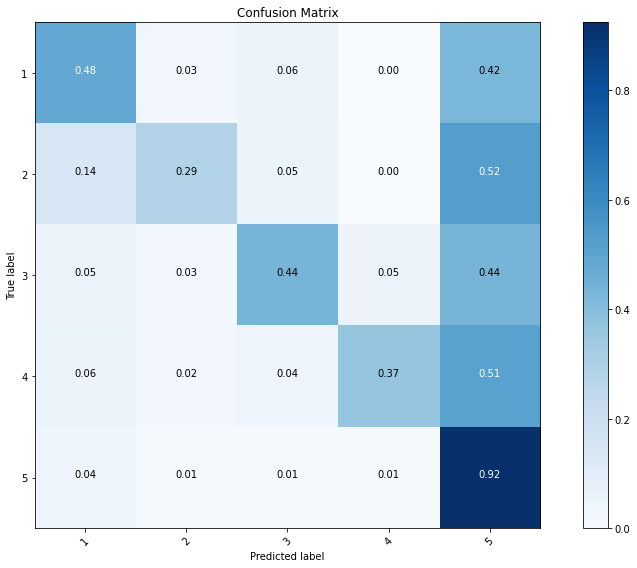

In [0]:
plt.figure(figsize=(12.0,8.0))
plot_confusion_matrix(matrix_conf, classes = ["1","2","3","4","5"], title = "Confusion Matrix", normalize = True)

### 3.5.2 Second version

In [0]:
# Definition of the random seach
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,   roc_auc_score, make_scorer,f1_score
scoring_evals = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score),'Recall': make_scorer(recall_score)}
scorer = make_scorer(f1_score, average = 'weighted')
random_search = RandomizedSearchCV(estimator = rf_sm, 
                                   param_distributions = random_grid, 
                                  n_iter = 50,
                                  scoring = scorer , 
                                  cv = 3, return_train_score = True)

random_search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 325 out of 325 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 325 out of 325 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 325 out of 325 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 325 out of 325 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend Th

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight={1: 3.9375,
                                                                  2: 6.72,
                                                                  3: 4.46017699,
                                                                  4: 1.38082192,
                                                                  5: 0.27406199},
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decre

In [0]:
print("The best hyperparameters from Random Search are:")
pprint(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
pprint(random_search.best_score_)

The best hyperparameters from Random Search are:
{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 325}

The mean accuracy of a model with these hyperparameters is:
0.745792403525841


In [0]:
y_pred_rf_sm_cv2=random_search.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 325 out of 325 | elapsed:    0.1s finished


In [0]:
report_rf_sm_cv2 = classification_report(y_test,y_pred_rf_sm_cv2, output_dict = True)
accuracy_score_rf_sm_cv2 = report_rf_sm_cv2["accuracy"]
f1_score_rf_sm_cv2 = report_rf_sm_cv2["macro avg"]["f1-score"]
print("Accuracy score for balanced estimation: ", accuracy_score_rf_sm_cv2)
matrix_conf = confusion_matrix(y_test, y_pred_rf_sm_cv2)

Accuracy score for balanced estimation:  0.7841269841269841


In [0]:
print("F1 score for balanced estimation: ", f1_score_rf_sm_cv2)

F1 score for balanced estimation:  0.5442778347572909


Normalized confusion matrix


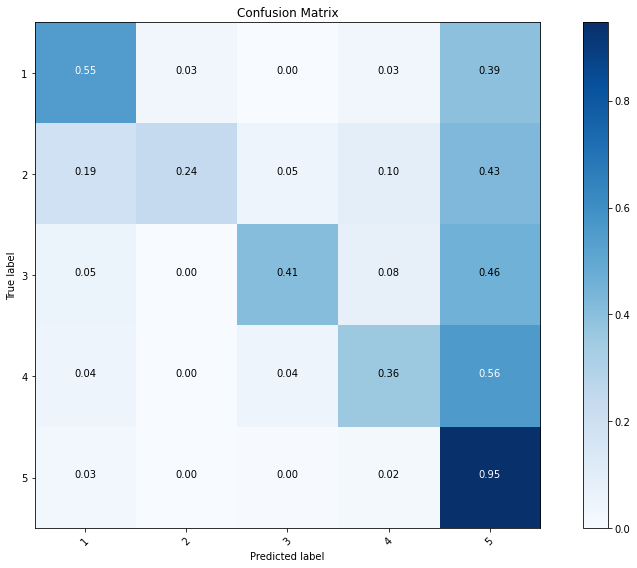

In [0]:
plt.figure(figsize=(12.0,8.0))
plot_confusion_matrix(matrix_conf, classes = ["1","2","3","4","5"], title = "Confusion Matrix", normalize = True)

### 3.5.3 Third version

We have used the smote minority argument which resamples only on the minority class (i.e. the second). We will now use the default argument that gives the same weight to each class.

In [0]:
oversample = SMOTE()
X_res, y_res =  oversample.fit_resample(X_train, y_train)
X_res.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(9195, 1500)

In [0]:
print("result of the oversampling: ",np.unique(y_res, return_counts = True))

result of the oversampling:  (array([1, 2, 3, 4, 5]), array([1839, 1839, 1839, 1839, 1839]))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.1s finished


Normalized confusion matrix


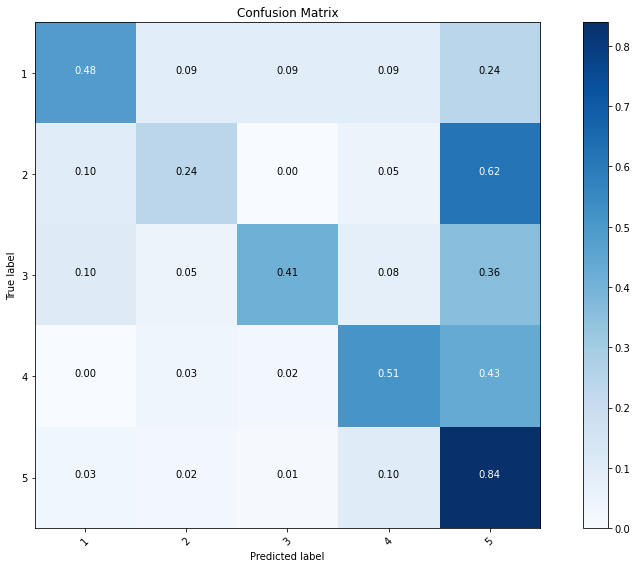

In [0]:
rf_sm_res = RandomForestClassifier(n_estimators = 300, criterion = 'entropy', random_state = 0, class_weight = "balanced", n_jobs=-1, verbose=1)
rf_sm_res.fit(X_res, y_res)
y_res_pred = rf_sm_res.predict(X_test)
plt.figure(figsize=(12.0,8.0))
plot_confusion_matrix(confusion_matrix(y_test, y_res_pred), classes = ["1","2","3","4","5"], title = "Confusion Matrix", normalize = True)

In [0]:
report_rf_sm_all = classification_report(y_test, y_res_pred, output_dict = True)
accuracy_score_rf_sm_all = report_rf_sm_all["accuracy"]
f1_score_rf_sm_all =  report_rf_sm_all["macro avg"]["f1-score"]

In [0]:
print("Accuracy score for oversampling all resamples: ",accuracy_score_rf_sm_all)
print("F1 score for oversampling all resamples: ",f1_score_rf_sm_all)

Accuracy score for oversampling all resamples:  0.726984126984127
F1 score for oversampling all resamples:  0.5050785249414991


## 3.6 We try a SVM

In [0]:
from sklearn.model_selection import train_test_split
y = df.rating
X_train, X_devtest, y_train, y_devtest = train_test_split(X_v2, y, test_size=0.4, random_state=42)

In [0]:
# create dev 20% test 20% (hence 50% from the 40%)
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,1)) #strip_accents = "unicode", decode_error= "replace", stop_words = "english",
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(1890, 3325)

In [0]:
# for dev set
X_dev_cv = cv.transform(X_dev)
X_dev_cv.shape

(630, 3325)

In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)
y_train_lb = lb_trained.transform(y_train)
y_dev_lb = lb_trained.transform(y_dev)
print(y_train_lb.shape, y_dev_lb.shape)

(1890, 5) (630, 5)


In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
svm = SVC(verbose=1, random_state=42, class_weight = weight)
svm.fit(X_train_cv, y_train)
pred = svm.predict(X_dev_cv)

[LibSVM]

In [0]:
report_svm = classification_report(y_test, pred, output_dict = True)

In [0]:
accuracy_score_svm = report_svm["accuracy"]
f1_score_svm = report_svm["macro avg"]["f1-score"]
f1_score_svm

0.22741766974721195

## 3.7 Multi Class Classification : Logistic

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["reviews"], df['rating'], random_state = 42)

### 3.7.1 We transform text to array

In [0]:
# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_train)

### 3.7.2 Then, we transform the training sample to a matrix

In [0]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<2362x3680 sparse matrix of type '<class 'numpy.int64'>'
	with 51225 stored elements in Compressed Sparse Row format>

### 3.7.3 Finaly, we modelize the relation between rating and reviews

In [0]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 500, multi_class="multinomial", solver = "lbfgs", C = 10) #reg softmax
model.fit(X_train_vectorized, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
from sklearn.metrics import accuracy_score
predictions = model.predict(vect.transform(X_test))
report_lr = classification_report(y_test, predictions, output_dict = True)
accuracy_score_lr = report_lr["accuracy"]
f1_score_lr = report_lr["macro avg"]["f1-score"]
print('AUC: ', accuracy_score_lr)

AUC:  0.7791878172588832


# 4. We regroup rating by sentiment (1 & 2 : negative, 4 et 5 positive)

In [0]:
df['Positively Rated'] = np.where(df['rating'] > 3, 1, 0) # We decide to regroup rating 3 with 1 and 2 for have more cases
df['Positively Rated'].mean()

0.8701587301587301

In [0]:
# creating the Bag of words Model
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=1500)
X=cv.fit_transform(exemple).toarray()
y=df.iloc[:,6].values

In [0]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [0]:
# We define the model for tune it
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 0, class_weight = "balanced", n_jobs=-1, verbose=1)
scorer = make_scorer(f1_score, average = 'weighted')
# Definition of the random seach
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = rfc, 
                                   param_distributions = random_grid, 
                                  n_iter = 50,
                                  scoring = scorer,
                                  cv = 3)

random_search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    9.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 550 out of 550 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    9.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | ela

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
      

In [0]:
y_pred_rf_grouped=random_search.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 325 out of 325 | elapsed:    0.1s finished


In [0]:
report = classification_report(y_test, y_pred_rf_grouped, output_dict = True)

In [0]:
accuracy_score_rf_grouped = report["accuracy"]
print("Accuracy score for balanced estimation: ", accuracy_score_rf_grouped)
matrix_conf = confusion_matrix(y_test, y_pred_rf_grouped)

Accuracy score for balanced estimation:  0.8968253968253969


# Summary of the set of models

In [0]:
print("Basic Random Forest: ",accuracy_score_rf2)
print("Cross validation of Random Forest with balanced class weight: ",accuracy_score_rf_cv)
print("Cross validation of Random Forest with oversampling only on the minority class and accuracy score: ",accuracy_score_rf_sm_cv)
print("Cross validation of Random Forest with oversampling only on the minority class and f1-score: ",accuracy_score_rf_sm_cv2)
print("Random Forest with oversampling on all classes: ",accuracy_score_rf_sm_all)
print("Support vector machine: ",accuracy_score_svm)
print("Logistic Regression (softmax): ",accuracy_score_lr)
print("Random Forest on grouped classes by sentiment: ",accuracy_score_rf_grouped)




Basic Random Forest:  0.8015873015873016
Cross validation of Random Forest with balanced class weight:  0.7888888888888889
Cross validation of Random Forest with oversampling only on the minority class and accuracy score:  0.7698412698412699
Cross validation of Random Forest with oversampling only on the minority class and f1-score:  0.7841269841269841
Random Forest with oversampling on all classes:  0.726984126984127
Support vector machine:  0.5158730158730159
Logistic Regression (softmax):  0.7791878172588832
Random Forest on grouped classes by sentiment:  0.8968253968253969
